__WARNING__: This version of the notebook was what I was left with at the end of presenting it to two students on Dec 18th, 2015. It may not execute cleanly from beginning to end, as I would often create a cell and write/execute new code, etc. I'm even leaving the cell/execution output in. The previous checkin in the git repo _is_ clean.

# Manipulating Tick Data with pandas

We will work with data from [QuantQuote](https://quantquote.com/historical-stock-data).

- Dimensions: date, time, stock symbol
- Metrics: opening, high, low and closing prices, as well as trade volume
- Frequency: daily
- Dates: 1998 to 2015
- Scope: 500 stock symbols that constitute the S&P500 as of Dec 2015.

Let's get the data

In [3]:
from urllib.request import urlretrieve  # In Python 2: urllib.urlretrieve
from zipfile import ZipFile
import os.path

def download(url):
    local_fname = url.split('/')[-1]
    if os.path.exists(local_fname):
        return local_fname
    else:
        urlretrieve(url, local_fname)
        return local_fname

data_url = 'http://quantquote.com/files/quantquote_daily_sp500_83986.zip'
metadata_url = 'https://quantquote.com/docs/QuantQuote_Minute.pdf'

# Download data
## data_fname = download(data_url)
# Extract the data
with ZipFile('quantquote_daily_sp500_83986.zip') as zf:
    zf.extractall()

# Download PDF with the metadata
## metadata_fname = download(metadata_url)

For each one of the 500 stock symbols, we have a file. Here is a sample:

In [2]:
from pprint import pprint

data_dir = os.path.join('quantquote_daily_sp500_83986', 'daily')
pprint(os.listdir(data_dir)[:10])

['table_a.csv',
 'table_aa.csv',
 'table_aapl.csv',
 'table_abbv.csv',
 'table_abc.csv',
 'table_abt.csv',
 'table_ace.csv',
 'table_acn.csv',
 'table_act.csv',
 'table_adbe.csv']


From the downloaded PDF (see `metadata_fname`) we can obtain the field names (and their descriptions):

In [11]:
fieldnames = [
    'date',
    'time',
    'open',
    'high',
    'low',
    'close',
    'volume' 
]

## Building the dataset for a single stock symbol

We can now easily import the data of a single stock, for example, Apple (AAPL). We will drop the `time` field because it's useless.

First, let's get set to work with dataframes and matplotlib visualizations.

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
%matplotlib inline
print(plt.style.available)

['seaborn-muted', 'grayscale', 'seaborn-dark', 'seaborn-ticks', 'dark_background', 'seaborn-white', 'bmh', 'seaborn-whitegrid', 'seaborn-deep', 'seaborn-colorblind', 'seaborn-bright', 'seaborn-pastel', 'classic', 'ggplot', 'seaborn-poster', 'fivethirtyeight', 'seaborn-paper', 'seaborn-darkgrid', 'seaborn-dark-palette', 'seaborn-talk', 'seaborn-notebook']


In [9]:
plt.style.use('dark_background')

In [12]:
def import_data(symbol, fieldnames=fieldnames, set_index=True, add_symbol=False):
    data_path = os.path.join('quantquote_daily_sp500_83986',
                             'daily',
                             'table_' + symbol + '.csv')
    data = pd.read_csv(data_path,
                       names=fieldnames).drop('time', axis=1)
    data['date'] = pd.to_datetime(data.date, format='%Y%m%d')
    if set_index:
        data.set_index('date', inplace=True)
    if add_symbol:
        data['symbol'] = symbol
    return data

aapl = import_data('aapl')

In [13]:
print(aapl.info())
print(aapl.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3926 entries, 1998-01-02 to 2013-08-09
Data columns (total 5 columns):
open      3926 non-null float64
high      3926 non-null float64
low       3926 non-null float64
close     3926 non-null float64
volume    3926 non-null float64
dtypes: float64(5)
memory usage: 184.0 KB
None
              open         high          low        close        volume
count  3926.000000  3926.000000  3926.000000  3926.000000  3.926000e+03
mean    131.046735   132.547087   129.276820   130.936396  1.996621e+07
std     165.720993   167.175882   163.849101   165.519449  1.395386e+07
min       3.313970     3.950980     3.282360     3.890200  1.437792e+06
25%      10.879200    11.127125    10.645725    10.892600  1.067201e+07
50%      52.551700    53.052600    51.491650    52.308600  1.581984e+07
75%     184.108000   185.625500   180.998750   184.118500  2.529142e+07
max     685.808000   688.660000   683.287000   685.662000  2.339738e+08


We can quickly look at things like the closing prices:

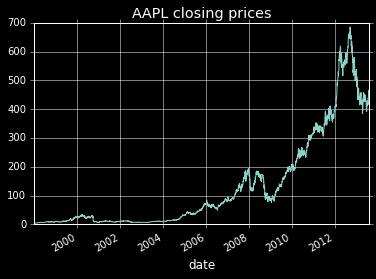

In [14]:
aapl.close.plot(title='AAPL closing prices')

This kind of plot where you have a lot of data points in the x-axis begs for interactivity: sometimes we want to inspect prices dates where something happened. Bokeh can help greatly here, allowing you to zoom in the dates you are interested in easily.


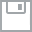
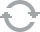
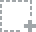
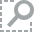
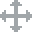
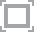
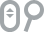
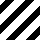
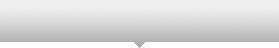
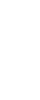
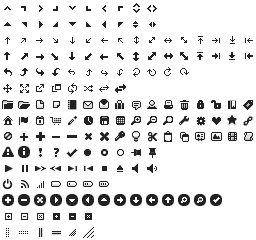
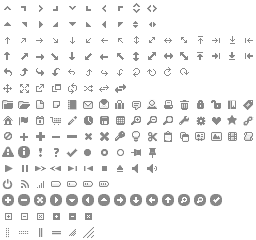
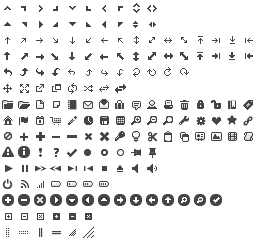
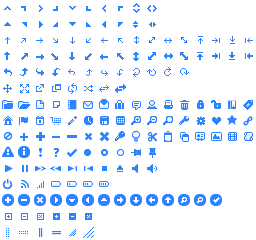
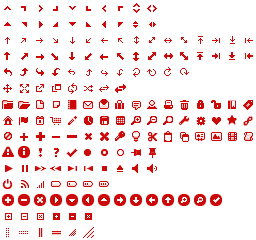
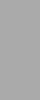
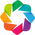
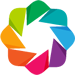

In [16]:
import bokeh.charts, bokeh.io
bokeh.io.output_notebook()

In [17]:
p = bokeh.charts.Line(aapl.close.reset_index(), x='date', y='close')
p.notebook(True).show()

We can also look at the relative difference between open and close prices:

count    3926.000000
mean        0.000325
std         0.025235
min        -0.114119
25%        -0.013423
50%         0.000000
75%         0.012963
max         0.192220
dtype: float64


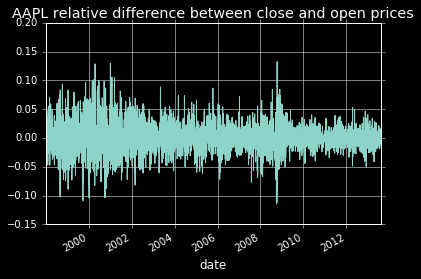

In [18]:
_df = (aapl.close - aapl.open) / aapl.open
print(_df.describe())
_df.plot(title='AAPL relative difference between close and open prices')

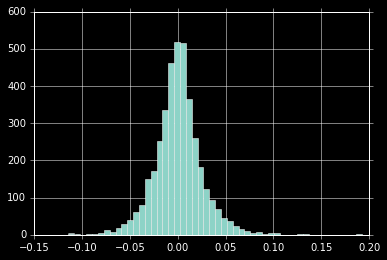

In [19]:
_df.hist(bins=50)

## Building a dataset for all stocks

First, you should check if the data is "too big" just by looking at its size. It's 35M compressed, so we will be fine loading it all in memory.

In [26]:
_data_dir = os.path.join('quantquote_daily_sp500_83986', 'daily')

def make_dataset(data_dir=_data_dir):
    "Import csv files from data_dir"
    data_files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]
    symbols = [os.path.splitext(f)[0].split('_')[1] for f in data_files]
    df_by_symbol = (import_data(s, set_index=False, add_symbol=True)
                    for s in symbols)
    df = pd.concat(df_by_symbol)
    
    # Encode categorical variables efficiently
    ## df['symbol'] = df.symbol.astype('category')
    # Set an index and assert it is well behaved
    df = df.set_index(['symbol', 'date']).sort_index()
    assert df.index.is_unique and df.index.is_monotonic
    return df

In [27]:
%time df = make_dataset()

CPU times: user 6.28 s, sys: 925 ms, total: 7.21 s
Wall time: 7.55 s


We can now access the data in various ways:

In [28]:
df.head()

open     high      low    close        volume
symbol date                                                        
a      1999-11-18  42.2076  46.3820  37.4581  39.1928  43981812.870
       1999-11-19  39.8329  39.8885  36.9293  37.6251  11390201.186
       1999-11-22  38.3208  40.0091  37.1613  39.9442   4654716.475
       1999-11-23  39.4247  40.4729  37.3375  37.5138   4268902.729
       1999-11-24  37.2262  38.9052  37.1056  38.0889   3602367.389

In [29]:
df.loc['aapl'].head()

,open,high,low,close,volume
date,,,,,
1998-01-02,3.31397,3.95098,3.28236,3.95098,24947201.10
1998-01-05,4.01177,4.02635,3.69325,3.89020,22344145.08
1998-01-06,3.87561,4.98432,3.58628,4.60502,63150252.55
1998-01-07,4.57341,4.68040,4.20871,4.24032,36978255.52
1998-01-08,4.24032,4.52965,4.11875,4.39107,27687622.95


Let's say now we want to visualize the closing prices for Microsoft (MSFT) and Apple (AAPL) stock:

symbol         aapl     msft
date                        
1998-01-02  3.95098  12.2332
1998-01-05  3.89020  12.1753
1998-01-06  4.60502  12.2510
1998-01-07  4.24032  12.0931
1998-01-08  4.39107  12.1753


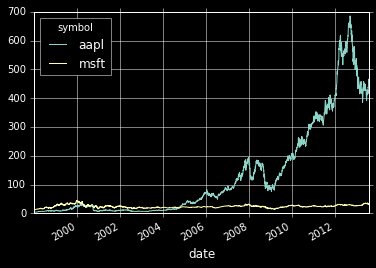

In [40]:
_symbols = ['aapl', 'msft']
_df = df.loc[_symbols].close.unstack('symbol')

print(_df.head())
_df.plot()

The main thing to remember about plotting with pandas is __the x-axis corresponds to the index and each column corresponds to a different series__.

Log-scale on the closing price might help clear things up here:

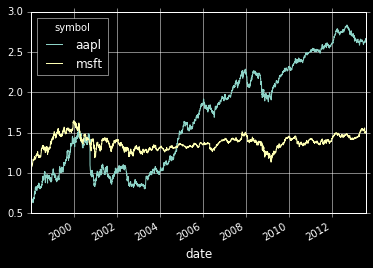

In [42]:
import numpy as np

# one way of using log scale in the y-axis
np.log10(_df).plot()

The plots handle missing data gracefully too:

symbol         aapl  goog     msft     yhoo
date                                       
1998-01-02  3.95098   NaN  12.2332  4.14437
1998-01-05  3.89020   NaN  12.1753  3.92563
1998-01-06  4.60502   NaN  12.2510  3.99250
1998-01-07  4.24032   NaN  12.0931  3.98813
1998-01-08  4.39107   NaN  12.1753  4.01562


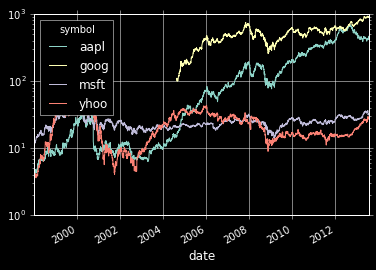

In [43]:
_symbols = ['aapl', 'msft', 'goog', 'yhoo']
_df = df.loc[_symbols].close.unstack('symbol')

print(_df.head())
_df.plot(logy=True) # another way of using log scale in the y-axis

Notice how the legend covers part of the plot. Pandas plots are just matplotlib plots and thus you can [modify their legend](http://matplotlib.org/users/legend_guide.html) the same way:

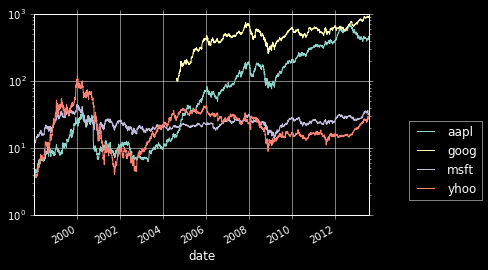

In [44]:
# Sets the upper-left corner of the legend box at position bbox_to_anchor
# bbox_to_anchor=(0.5,0.5) would be the center of the plot

_df.plot(logy=True).legend(bbox_to_anchor=(1.1, 0.5), loc='upper left')

# exercise: restrict the plot to the period after the first iPhone release (June 2007)

We can also plot one stock against another:

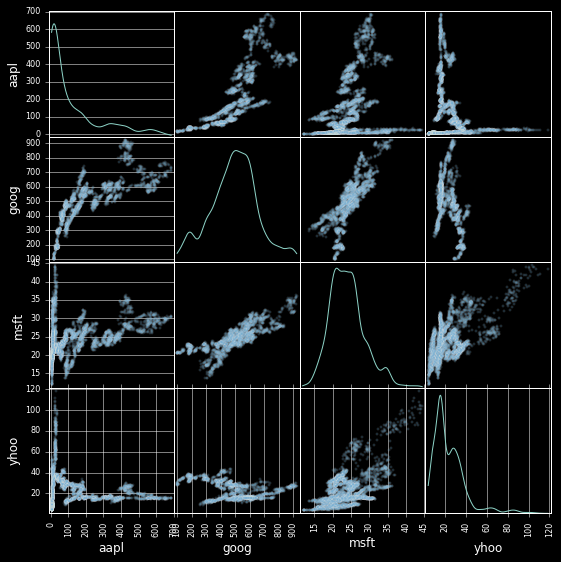

In [45]:
from pandas.tools.plotting import scatter_matrix

scatter_matrix(_df, alpha=0.2, figsize=(9, 9), diagonal='kde');

You may also want to know how much you would have made over time from 1 dollar invested on each stock on Jan 1st 2006:

symbol         aapl    goog     msft   yhoo
date                                       
2006-01-03  72.6300  434.89  22.8797  40.87
2006-01-04  72.8440  444.78  22.9991  40.96
2006-01-05  72.2118  451.05  22.9906  41.52
2006-01-06  74.1180  465.77  22.9565  43.13
2006-01-09  73.9527  466.89  22.9309  43.38


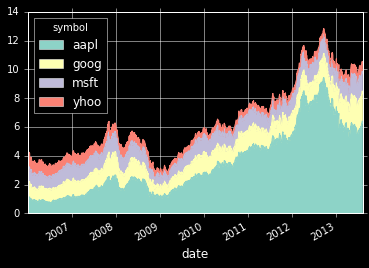

In [58]:
_symbols = ['aapl', 'msft', 'goog', 'yhoo']
_df = df.loc[_symbols].close.unstack('symbol').loc['2006':]
print(_df.head())


_df.div(_df.iloc[0]).plot(kind='area')

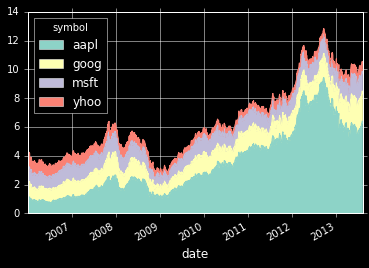

In [59]:
# Only on pandas 0.17+

_df.div(_df.iloc[0]).plot.area()

## The most traded stocks

We could want to restrict attention to the most traded stocks. To find 20 most traded stocks:

In [101]:
_df0 = df.volume.groupby(level='symbol').sum()
_df0.sort(ascending=False)
most_traded_symb = _df0.index.tolist()
most_traded_symb[:20]

/Users/gpfreitas/local/opt/miniconda3/envs/findata_py35/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  from ipykernel import kernelapp as app


['bac',
 'msft',
 'intc',
 'csco',
 'ge',
 'mo',
 'orcl',
 'pfe',
 'f',
 'amat',
 'dell',
 'yhoo',
 'wfc',
 'qcom',
 'jpm',
 's',
 'aapl',
 't',
 'emc',
 'gild']

In [ ]:
# pandas 0.17+

most_traded_symb = (
    df.groupby(level='symbol')
      .sum()
      .sort_values(by='volume', ascending=False)
      .index
      .tolist()
)

most_traded_symb[:20]

Why isn't Google there? Let's see where Google is in the list:

In [102]:
most_traded_symb.index('goog')

219

Wow, not even close to top 20 most traded. I wonder why.

In [114]:
df.head()

open     high      low    close        volume
symbol date                                                        
a      1999-11-18  42.2076  46.3820  37.4581  39.1928  43981812.870
       1999-11-19  39.8329  39.8885  36.9293  37.6251  11390201.186
       1999-11-22  38.3208  40.0091  37.1613  39.9442   4654716.475
       1999-11-23  39.4247  40.4729  37.3375  37.5138   4268902.729
       1999-11-24  37.2262  38.9052  37.1056  38.0889   3602367.389

In [ ]:
top20symb = most_traded_symb[:20]

In [127]:
(
    df[['close']]
    .unstack(level='symbol')
    .close[top20symb]
)

symbol,bac,msft,intc,csco,ge,mo,orcl,pfe,f,amat,dell,yhoo,wfc,qcom,jpm,s,aapl,t,emc,gild
date,,,,,,,,,,,,,,,,,,,,
1998-01-02,18.7499,12.2332,13.9559,9.17855,16.0195,4.65115,3.67267,15.7951,11.9377,6.63895,10.4144,4.14437,12.7300,2.71898,23.2635,19.7192,3.95098,18.9224,7.11535,1.19531
1998-01-05,19.2905,12.1753,14.3037,9.15009,16.3447,4.70871,3.74312,16.7389,11.9377,7.07411,10.7330,3.92563,12.6463,2.75519,23.7137,19.5695,3.89020,18.4174,7.06904,1.21500
1998-01-06,19.0403,12.2510,14.0635,9.04101,16.1127,4.71590,3.64225,16.2146,11.7204,6.69897,10.7488,3.99250,12.5025,2.72895,22.6569,20.1242,4.60502,18.3063,6.85696,1.22281
1998-01-07,19.1175,12.0931,13.9559,8.76436,16.2211,4.81150,3.37169,16.3467,11.6292,6.31097,10.4752,3.98813,12.2717,2.50906,22.7224,19.8247,4.24032,18.4532,6.70340,1.21500
1998-01-08,18.8858,12.1753,14.2672,8.87344,16.0997,4.77963,3.25161,16.3341,11.1184,6.28310,10.4898,4.01562,12.5025,2.53530,22.0481,19.1883,4.39107,18.3566,6.59614,1.23438
1998-01-09,18.2463,11.8597,13.8348,8.55727,15.6400,4.65732,3.02267,15.5079,10.8273,6.00228,10.1176,3.85938,11.9774,2.44346,21.5598,19.1032,4.43726,18.1356,6.27682,1.19938
1998-01-12,17.9960,12.0987,14.5247,8.81337,16.1669,4.76730,2.88178,16.0322,11.1505,6.01514,10.5968,3.90625,12.2082,2.46970,21.6127,19.4436,4.46886,18.4201,6.15494,1.14062
1998-01-13,17.9373,12.3443,14.7840,8.83392,16.1821,4.91428,3.07230,16.2020,11.6292,6.43101,10.9009,4.10938,12.0844,2.55839,21.9699,19.5491,4.76306,18.6107,6.88622,1.20125
1998-01-14,18.7499,12.2454,14.4959,9.01098,16.1279,4.83719,3.13154,16.3195,11.9524,6.31097,11.1137,4.19562,12.4590,2.55209,22.0883,19.7192,4.78738,18.7072,7.03978,1.17781


In [126]:
_df2 = df[['close']]
_df3 = _df2.unstack(level='symbol')
_df3.close[top20symb]

symbol,bac,msft,intc,csco,ge,mo,orcl,pfe,f,amat,dell,yhoo,wfc,qcom,jpm,s,aapl,t,emc,gild
date,,,,,,,,,,,,,,,,,,,,
1998-01-02,18.7499,12.2332,13.9559,9.17855,16.0195,4.65115,3.67267,15.7951,11.9377,6.63895,10.4144,4.14437,12.7300,2.71898,23.2635,19.7192,3.95098,18.9224,7.11535,1.19531
1998-01-05,19.2905,12.1753,14.3037,9.15009,16.3447,4.70871,3.74312,16.7389,11.9377,7.07411,10.7330,3.92563,12.6463,2.75519,23.7137,19.5695,3.89020,18.4174,7.06904,1.21500
1998-01-06,19.0403,12.2510,14.0635,9.04101,16.1127,4.71590,3.64225,16.2146,11.7204,6.69897,10.7488,3.99250,12.5025,2.72895,22.6569,20.1242,4.60502,18.3063,6.85696,1.22281
1998-01-07,19.1175,12.0931,13.9559,8.76436,16.2211,4.81150,3.37169,16.3467,11.6292,6.31097,10.4752,3.98813,12.2717,2.50906,22.7224,19.8247,4.24032,18.4532,6.70340,1.21500
1998-01-08,18.8858,12.1753,14.2672,8.87344,16.0997,4.77963,3.25161,16.3341,11.1184,6.28310,10.4898,4.01562,12.5025,2.53530,22.0481,19.1883,4.39107,18.3566,6.59614,1.23438
1998-01-09,18.2463,11.8597,13.8348,8.55727,15.6400,4.65732,3.02267,15.5079,10.8273,6.00228,10.1176,3.85938,11.9774,2.44346,21.5598,19.1032,4.43726,18.1356,6.27682,1.19938
1998-01-12,17.9960,12.0987,14.5247,8.81337,16.1669,4.76730,2.88178,16.0322,11.1505,6.01514,10.5968,3.90625,12.2082,2.46970,21.6127,19.4436,4.46886,18.4201,6.15494,1.14062
1998-01-13,17.9373,12.3443,14.7840,8.83392,16.1821,4.91428,3.07230,16.2020,11.6292,6.43101,10.9009,4.10938,12.0844,2.55839,21.9699,19.5491,4.76306,18.6107,6.88622,1.20125
1998-01-14,18.7499,12.2454,14.4959,9.01098,16.1279,4.83719,3.13154,16.3195,11.9524,6.31097,11.1137,4.19562,12.4590,2.55209,22.0883,19.7192,4.78738,18.7072,7.03978,1.17781


In [113]:
_df0 = df.reset_index()

_df0[_df0.symbol.isin(most_traded_symb[:20])][['symbol', 'date', 'open', 'close']].set_index(['symbol', 'date']).head()

open    close
symbol date                        
aapl   1998-01-02  3.31397  3.95098
       1998-01-05  4.01177  3.89020
       1998-01-06  3.87561  4.60502
       1998-01-07  4.57341  4.24032
       1998-01-08  4.24032  4.39107

In [110]:
df.loc?

In [128]:
# exercise: select different combinations of stock symbols and dates
# See http://pandas.pydata.org/pandas-docs/stable/advanced.html#using-slicers

top20 = df.loc[(most_traded_symb[:20],slice(None)), ['open', 'close']]

top20.head()

open    close
symbol date                        
aapl   1998-01-02  3.31397  3.95098
       1998-01-05  4.01177  3.89020
       1998-01-06  3.87561  4.60502
       1998-01-07  4.57341  4.24032
       1998-01-08  4.24032  4.39107

In [129]:
top20.close.unstack('symbol').head()

symbol,aapl,amat,bac,csco,dell,emc,f,ge,gild,intc,jpm,mo,msft,orcl,pfe,qcom,s,t,wfc,yhoo
date,,,,,,,,,,,,,,,,,,,,
1998-01-02,3.95098,6.63895,18.7499,9.17855,10.4144,7.11535,11.9377,16.0195,1.19531,13.9559,23.2635,4.65115,12.2332,3.67267,15.7951,2.71898,19.7192,18.9224,12.7300,4.14437
1998-01-05,3.89020,7.07411,19.2905,9.15009,10.7330,7.06904,11.9377,16.3447,1.21500,14.3037,23.7137,4.70871,12.1753,3.74312,16.7389,2.75519,19.5695,18.4174,12.6463,3.92563
1998-01-06,4.60502,6.69897,19.0403,9.04101,10.7488,6.85696,11.7204,16.1127,1.22281,14.0635,22.6569,4.71590,12.2510,3.64225,16.2146,2.72895,20.1242,18.3063,12.5025,3.99250
1998-01-07,4.24032,6.31097,19.1175,8.76436,10.4752,6.70340,11.6292,16.2211,1.21500,13.9559,22.7224,4.81150,12.0931,3.37169,16.3467,2.50906,19.8247,18.4532,12.2717,3.98813
1998-01-08,4.39107,6.28310,18.8858,8.87344,10.4898,6.59614,11.1184,16.0997,1.23438,14.2672,22.0481,4.77963,12.1753,3.25161,16.3341,2.53530,19.1883,18.3566,12.5025,4.01562


We may want to exclude AAPL from a visualizations of returns over time on a dollar invested:

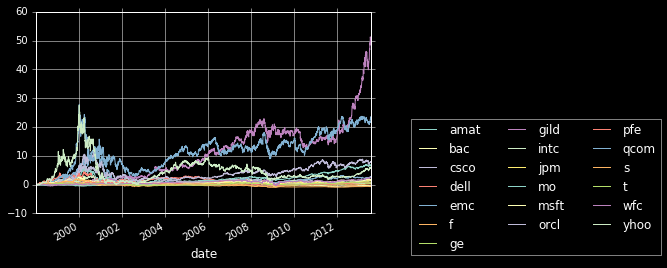

In [136]:
_df1 = _df0.div(_df0.iloc[0]).close
_df2 = _df1 - 1
_df2.plot().legend(bbox_to_anchor=(1.1, 0.5), loc='upper left', ncol=3)

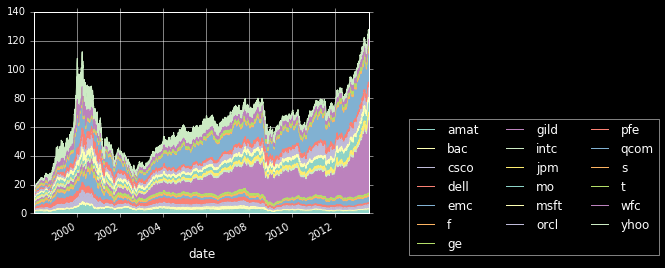

In [130]:
_df0 = top20.drop('aapl').unstack(level='symbol')
_df0.div(_df0.iloc[0]).close.plot.area().legend(bbox_to_anchor=(1.1, 0.5), loc='upper left', ncol=3)

In [ ]:
# Exercise: which days of the week see the most trade? What about days of the month?

## The Olympics, bets, and stochastic dominance

We will now look into a visual way of choosing among multiple alternatives that give you a random return.

Before that, a short detour into athletics: in the 2012 summer olympics, these were the number of gold, silver and bronze medals for the US, China, Russia and Great Britain, respectively:

- US: 46,29,29
- China: 38,27,22
- Russia: 24,25,33
- Great Britain: 29, 17,19

How do these olympic teams compare? Who is better: Great Britain or Russia? Here is a visual answer:

In [137]:
medals = {'US': [46,29,29],
          'China': [38,27,22],
          'Russia': [24,25,33],
          'Great Britain': [29, 17,19],
          'medals': ['gold', 'silver', 'bronze']}

summer_olymp = pd.DataFrame(medals).set_index('medals')
summer_olymp

,China,Great Britain,Russia,US
medals,,,,
gold,38,29,24,46
silver,27,17,25,29
bronze,22,19,33,29


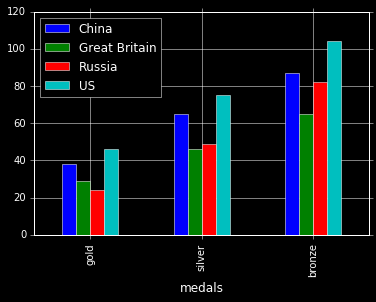

In [140]:
# Note that to interpret the index/x-axis, you need to know we are doing a cumulative sum
# It's easy to do it this way, but it can confuse your audience. Be careful.

summer_olymp.cumsum().plot.bar()

It follows from above that, unanmbiguously, US > China > {Russia, Great Britan}. However, whether Russia beats Great Britain or vice-versa depends on the relative weights of each type of medal.

Note that Great Britan has more gold medals than Russia, but Russia has more medals than Great Britan when we count gold and silver, or when we count all three types of medals.

The following plot is another way of visualizing the same information.

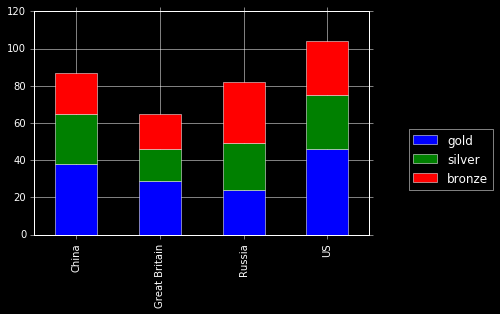

In [141]:
summer_olymp.transpose().plot.bar(stacked=True).legend(bbox_to_anchor=(1.1, 0.5), 
                                                       loc='upper left', ncol=1)

We can use similar ideas when making bets, choosing models, etc. as long as the returns from our choice can be quantified in a probability distribution.

For simplicity, imagine stock returns are independent, and that you need to choose one stock to "bet on". Betting on a stock means that you will buy 1 dollar of it when the market opens, and sell the stock you bought in the end of the day. Again, for simplicity, restrict attention to the stocks ['ge', 'nflx', 'yhoo'].

One way to proceed could be as follows. We compare the empirical cumulative distribution function (ECDF) of each alternative: the alternative with the "lowest" ECDF (if there is one), is the best alternative. That is because that "lowest" ECDF unambiguously puts more mass on higher-value outcomes. In particular, if we ranked the alternatives by the mean, median, quartiles, etc., all these measures would agree that the alternative with the lowest ECDF would be the best. In that case, we say this lowest ECDF stochastically dominates all other distributions in a first-order sense.

If there is no uniformly lowest ECDF, then we need to analyze the graph and see where various ECDFs cross each other to make a judgement call.

You may want to look up the definition of [cumulative distribution function](https://en.wikipedia.org/wiki/Cumulative_distribution_function) and [first-order stochastic dominance](https://en.wikipedia.org/wiki/Stochastic_dominance#First-order_stochastic_dominance).

In [142]:
spread = ((df.close - df.open) / df.open).loc[['ge', 'nflx', 'yhoo']]

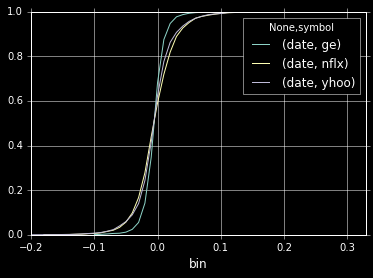

In [143]:
def plot_cdfs(spread):
    binned = (np.round(spread * 100) /100).reset_index().groupby(['symbol', 0]).count()
    binned.index.names = ['symbol', 'bin']
    numerator = binned.unstack(level='symbol').cumsum()
    denominator = binned.unstack(level='symbol').sum()
    return numerator.div(denominator).plot()

plot_cdfs(spread)

As you can see, there is no clear winner: the options with good returns are also the options with high costs.

What if you could somehow guess if the stock will go up or down in that day. In that case, let's say a bet means you can also _sell_ 1 dollar's worth of the stock in the beginning of the day, then buy back that same amount of stock at the end of the day.

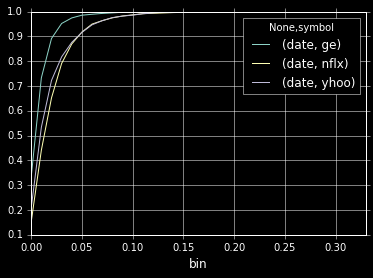

In [144]:
plot_cdfs(np.abs(spread))

And in this case Netflix looks like the winner, beating Yahoo by a narrow margin.

## Panel data

In [145]:
pan = df.to_panel()
pan

<class 'pandas.core.panel.Panel'>
Dimensions: 5 (items) x 500 (major_axis) x 3926 (minor_axis)
Items axis: open to volume
Major_axis axis: a to zmh
Minor_axis axis: 1998-01-02 00:00:00 to 2013-08-09 00:00:00

In [148]:
# Note that dates go in the columns, for some reason

pan.loc['open'].head().transpose()

symbol,a,aa,aapl,abbv,abc
date,,,,,
1998-01-02,NaN,13.37540,3.31397,NaN,6.50130
1998-01-05,NaN,13.49160,4.01177,NaN,6.42428
1998-01-06,NaN,13.51590,3.87561,NaN,6.42428
1998-01-07,NaN,13.03440,4.57341,NaN,6.27808
1998-01-08,NaN,13.30420,4.24032,NaN,6.32049
1998-01-09,NaN,12.73080,4.40808,NaN,6.36848
1998-01-12,NaN,12.19120,4.24032,NaN,6.02695
1998-01-13,NaN,12.55470,4.52965,NaN,6.00575
1998-01-14,NaN,12.43850,4.83357,NaN,6.12517


In [ ]:
# This fixes it

pan.loc['close'].transpose().head()

Another way to build a panel:

In [149]:
dd = {sym: df.loc[sym] for sym in most_traded_symb[:20]}
panel = pd.Panel(dd)

In [152]:
panel.loc['ge'].head()

# Note that this time the dates came correctly in the rows

,open,high,low,close,volume
date,,,,,
1998-01-02,15.8959,16.0195,15.7202,16.0195,12848723.479
1998-01-05,16.1409,16.3447,16.0997,16.3447,24173221.188
1998-01-06,16.1669,16.3035,16.0455,16.1127,17986834.717
1998-01-07,15.9501,16.2363,15.9241,16.2211,14521454.600
1998-01-08,16.1669,16.3295,16.0585,16.0997,17095812.619


In [154]:
panel.loc[:,'1998-01-02'].transpose()

,open,high,low,close,volume
aapl,3.31397,3.95098,3.28236,3.95098,24947201.100
amat,6.48460,6.64538,6.43101,6.63895,18198228.932
bac,18.84560,18.96300,18.69120,18.74990,3668616.312
csco,8.95248,9.22914,8.79440,9.17855,42370893.628
dell,10.31470,10.45940,10.18570,10.41440,38852740.516
emc,6.67414,7.16166,6.67414,7.11535,9182808.740
f,12.01410,12.06100,11.87590,11.93770,7442033.162
ge,15.89590,16.01950,15.72020,16.01950,12848723.479
gild,1.19531,1.20719,1.17188,1.19531,2876800.000
intc,13.58310,13.95590,13.54660,13.95590,49120779.560


In [155]:
panel.loc[:,:,'close'].head()

,aapl,amat,bac,csco,dell,emc,f,ge,gild,intc,jpm,mo,msft,orcl,pfe,qcom,s,t,wfc,yhoo
date,,,,,,,,,,,,,,,,,,,,
1998-01-02,3.95098,6.63895,18.7499,9.17855,10.4144,7.11535,11.9377,16.0195,1.19531,13.9559,23.2635,4.65115,12.2332,3.67267,15.7951,2.71898,19.7192,18.9224,12.7300,4.14437
1998-01-05,3.89020,7.07411,19.2905,9.15009,10.7330,7.06904,11.9377,16.3447,1.21500,14.3037,23.7137,4.70871,12.1753,3.74312,16.7389,2.75519,19.5695,18.4174,12.6463,3.92563
1998-01-06,4.60502,6.69897,19.0403,9.04101,10.7488,6.85696,11.7204,16.1127,1.22281,14.0635,22.6569,4.71590,12.2510,3.64225,16.2146,2.72895,20.1242,18.3063,12.5025,3.99250
1998-01-07,4.24032,6.31097,19.1175,8.76436,10.4752,6.70340,11.6292,16.2211,1.21500,13.9559,22.7224,4.81150,12.0931,3.37169,16.3467,2.50906,19.8247,18.4532,12.2717,3.98813
1998-01-08,4.39107,6.28310,18.8858,8.87344,10.4898,6.59614,11.1184,16.0997,1.23438,14.2672,22.0481,4.77963,12.1753,3.25161,16.3341,2.53530,19.1883,18.3566,12.5025,4.01562


In [156]:
panel.apply(lambda x: x.mean(), axis='major_axis')

,aapl,amat,bac,csco,dell,emc,f,ge,gild,intc,jpm,mo,msft,orcl,pfe,qcom,s,t,wfc,yhoo
open,131.046735,15.214902,23.519860,22.304004,24.631806,21.376098,12.284873,22.848173,13.985986,20.985366,33.206970,12.669968,24.102180,18.514151,20.653229,33.976111,15.824390,22.730478,22.801220,23.684036
high,132.547087,15.519632,23.808840,22.666440,25.046829,21.785563,12.465261,23.103479,14.176289,21.314285,33.684067,12.780212,24.400391,18.819606,20.890119,34.539132,16.074943,22.985423,23.089236,24.195115
low,129.276820,14.902008,23.215531,21.916157,24.215797,20.928719,12.086366,22.564163,13.788171,20.654509,32.716258,12.558630,23.804041,18.205174,20.401682,33.412418,15.561797,22.458788,22.498458,23.155324
close,130.936396,15.205181,23.506287,22.288960,24.637412,21.367771,12.268749,22.840240,13.985829,20.974653,33.206557,12.670182,24.101647,18.511671,20.649560,33.979884,15.816970,22.724083,22.801563,23.663451
volume,19966206.428361,28367898.543444,72976742.068844,56472562.937399,25957831.353455,18781020.827263,33052926.308911,43459113.621858,18647622.125637,66845549.699202,22517245.960958,40698844.726924,72380784.137779,39960836.419982,34449858.528212,23326476.481488,21716866.484955,19358900.795132,23341656.380687,24324544.317881


In [157]:
df.loc['nflx'].head()

,open,high,low,close,volume
date,,,,,
2002-05-23,8.095,8.700,8.02,8.380,14101400
2002-05-24,8.500,8.575,8.38,8.475,1506800
2002-05-28,8.495,8.625,8.13,8.130,917000
2002-05-29,8.150,8.150,7.60,7.770,953200
2002-05-30,7.755,7.755,7.50,7.500,1422400


Panels are more compelling when we have 3 bona-fide dimensions. Here we have only two: symbol and date.

To see how natural panels can be, imagine some transactions happening a market for a given good. Every transaction is recorded as 

    (buyer, seller, timestamp, quantity, payment)
    
Let's generate some data quickly.

In [158]:
from itertools import product, islice
import random

def mkt_data_gen():
    buyer = random.choice(['buyer_' + str(i) for i in range(3)])
    seller = random.choice(['seller_' + str(j) for j in range(4)])
    timestamp = random.choice(pd.date_range('2015-01-01', '2015-01-05'))
    quantity = random.randint(1,101)
    payment = np.random.lognormal(6, 2)
    return timestamp, buyer, seller, quantity, payment

transactions = pd.DataFrame(
    sorted([mkt_data_gen() for __ in range(100)]),
    columns=['timestamp', 'buyer', 'seller', 'quantity', 'payment']
).groupby(['timestamp', 'buyer', 'seller']).sum()


This is the hierarchical dataframe that represents the data:

In [159]:
transactions.head(20)

quantity        payment
timestamp  buyer   seller                           
2015-01-01 buyer_0 seller_0       104     232.371063
                   seller_1       161   12482.820595
                   seller_2        31      56.700516
                   seller_3        21  150277.037482
           buyer_1 seller_0       155    1656.132696
                   seller_1        92    4290.433509
                   seller_3       148    3852.803614
           buyer_2 seller_0       172    1082.701563
                   seller_1       120    4240.592600
                   seller_2        40     322.060354
                   seller_3        20   16890.852159
2015-01-02 buyer_0 seller_0       110     493.098623
                   seller_1        35       9.657409
                   seller_3       177    3546.879194
           buyer_1 seller_0       286   19243.896534
                   seller_1        91    3646.043147
                   seller_2        92    1572.685610
           buyer_2 seller_0       154    1659.678891
                   seller_1       125   30443.097493
                   seller_2       176  187567.255159

Let's focus on quantities only and format the table in a way that makes the two-sided nature of the market more obvious:

In [160]:
quantity = transactions.quantity

In [161]:
twosided_quantities = quantity.unstack(level='seller')
twosided_quantities

seller              seller_0  seller_1  seller_2  seller_3
timestamp  buyer                                          
2015-01-01 buyer_0       104       161        31        21
           buyer_1       155        92       NaN       148
           buyer_2       172       120        40        20
2015-01-02 buyer_0       110        35       NaN       177
           buyer_1       286        91        92       NaN
           buyer_2       154       125       176         8
2015-01-03 buyer_0        99       135        58        96
           buyer_1        54        18        45       139
           buyer_2       NaN       129        77       132
2015-01-04 buyer_0       NaN       259        79        24
           buyer_1        82        30       NaN       180
           buyer_2        34       NaN        86        41
2015-01-05 buyer_0        37       NaN       NaN        24
           buyer_1       182        56        44        53
           buyer_2        83       107       NaN        93

We are now going to create a panel as follows: for each timestamp, we will "hook" the corresponding subtable in the Panel, indexed by the timestamp.

In [162]:
_tr_dict = {ts: twosided_quantities.loc[ts]
            for ts in transactions.index.get_level_values(0).unique()}
tr_panel = pd.Panel(_tr_dict)

We can then look at the first sub-table

In [163]:
tr_panel.loc['2015-01-01']

seller,seller_0,seller_1,seller_2,seller_3
buyer,,,,
buyer_0,104,161,31,21
buyer_1,155,92,NaN,148
buyer_2,172,120,40,20


We could have gotten this from the parent dataframe in a very similar way:

In [164]:
quantity.loc['2015-01-01'].unstack(level='seller')

seller,seller_0,seller_1,seller_2,seller_3
buyer,,,,
buyer_0,104,161,31,21
buyer_1,155,92,NaN,148
buyer_2,172,120,40,20


or

In [165]:
quantity.xs('2015-01-01', level='timestamp').unstack(level='seller')

seller,seller_0,seller_1,seller_2,seller_3
buyer,,,,
buyer_0,104,161,31,21
buyer_1,155,92,NaN,148
buyer_2,172,120,40,20


For the second dimension:

In [169]:
tr_panel.loc[:,'buyer_1']

,2015-01-01 00:00:00,2015-01-02 00:00:00,2015-01-03 00:00:00,2015-01-04 00:00:00,2015-01-05 00:00:00
seller,,,,,
seller_0,155,286,54,82,182
seller_1,92,91,18,30,56
seller_2,NaN,92,45,NaN,44
seller_3,148,NaN,139,180,53


as opposed to

In [170]:
quantity.loc[:,'buyer_1']

timestamp   seller  
2015-01-01  seller_0    155
            seller_1     92
            seller_3    148
2015-01-02  seller_0    286
            seller_1     91
            seller_2     92
2015-01-03  seller_0     54
            seller_1     18
            seller_2     45
            seller_3    139
2015-01-04  seller_0     82
            seller_1     30
            seller_3    180
2015-01-05  seller_0    182
            seller_1     56
            seller_2     44
            seller_3     53
Name: quantity, dtype: int64

or

In [ ]:
quantity.xs('buyer_1', level='buyer').unstack(level='seller')

Finally, for the last dimension:

In [ ]:
tr_panel[:,:,'seller_1'].transpose()

as opposed to

In [ ]:
quantity.loc[:,:,'seller_1'].unstack(level='buyer')

or

In [ ]:
quantity.xs('seller_1', level='seller').unstack(level='buyer')

Simple exercise: eliminate all the calls to `unstack` and `transpose` in the examples above and see the how the data would have presented itself.